<a href="https://colab.research.google.com/github/majavk/EPRbiodose/blob/main/calibration_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Establishment of the calibration curve, dependence dose - g_effective values. 

In [ ]:
import numpy as np
from numpy import arange
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'my_folder'

file_type = '.csv'

filenames = list()
for filename in os.listdir(path=path):
    if filename.endswith(file_type):
        filenames.append(filename)


##Data manipulation and data extraction from the files acquired from the ESR spectometer.

In [ ]:
df_final = pd.DataFrame()

MIN_ROW = 85
for item in filenames:
    variable_filename = '_' + item
    variable_name_to_change = 'df_' + item
    variable_name_to_change = pd.read_csv(f'{path}/' + item, header=None).iloc[MIN_ROW:, :]
    field_variable_name_to_change = list()
    ampl_variable_name_to_change = list()
    for  row in variable_name_to_change.itertuples():
        field_variable_name_to_change.append(float(row[1].split(';')[0]))
        ampl_variable_name_to_change.append(float(row[1].split(';')[1]))
    row_field_variable ='new_field' + str(variable_filename)
    row_ampl_variable = 'new_ampl' + str(variable_filename)
    df_final[row_field_variable] = field_variable_name_to_change
    df_final[row_ampl_variable] = ampl_variable_name_to_change 


In [ ]:
df_Mn_left = df_final[(df_final.iloc[:,0]> 330.) & (df_final.iloc[:, 0] < 332.)]
df_geff = df_final[(df_final.iloc[:,0]> 334.) & (df_final.iloc[:, 0] < 337.)]

In [ ]:
data = df_Mn_left.to_dict()
s = pd.DataFrame()

for key, value in data.items():
    if 'ampl' in key:
        B_MN_left_variable = 'B_Mn_left_'+key
        B_MN_left_column_variable = 'B_Mn_left_column_'+key
        values_Mn = 'values_Mn_'+ key
        values_Mn = list()
        for x,y in value.items():
            values_Mn.append(y)
        s[B_MN_left_column_variable] = values_Mn


In [ ]:
data_1 = df_geff.to_dict()
s_1 = pd.DataFrame()

for key, value in data_1.items():
    if 'ampl'in key:
        B_g_eff_variable = 'B_g_eff_'+key
        B_g_eff_column_variable = 'B_g_eff_column_'+key
        values = 'values_'+ key
        values = list()
        for x,y in value.items():
            values.append(y)
        s_1[B_g_eff_column_variable] = values


In [ ]:
def g_values(B_Mn_left, B_g_eff):
    g_Mn_left = 2.03339
    g_eff = g_Mn_left * (B_Mn_left/B_g_eff)
    return g_eff


In [ ]:
max_names = list()
max_values = list()
max_index = list()
for item in s.columns.values.tolist():
    max_value = s[item].sort_values(ascending=False)[:1]
    max_names.append(max_value.name)
    max_values.append(max_value.values[0])
    max_index.append(list(max_value.index)[0])
    
zipped_Mn = zip(max_names, max_values, max_index)
ampl_data_Mn = list(zipped_Mn)


In [ ]:
max_names_1 = list()
max_values_1 = list()
max_index_1 = list()

for item in s_1.columns.values.tolist():
    max_value = s_1[item].sort_values(ascending=False)[:1]
    max_names_1.append(max_value.name)
    max_values_1.append(max_value.values[0])
    max_index_1.append(list(max_value.index)[0])
    
zipped_g_eff = zip(max_names_1, max_values_1, max_index_1)
ampl_data_g_eff = list(zipped_g_eff)


In [ ]:
zipped_g_eff_Mn = zip(max_names, max_values, max_index, max_names_1, max_values_1, max_index_1)
zipped_g_eff_Mn = list(zipped_g_eff_Mn)

In [ ]:
df = pd.DataFrame()

g_eff = list()
dose = list()
b_g_eff = list()
b_Mn_left = list()
for  name, value, index, name_1, value_1, index_1 in zipped_g_eff_Mn:
    replaced_name_1 = name_1[15:].replace('ampl', 'field')
    replaced_name = name[17:].replace('ampl', 'field')
    B_g_eff = df_geff[replaced_name_1].iloc[index_1]
    B_Mn_left = df_Mn_left[replaced_name].iloc[index]
    variable_name = 'g_eff_' + replaced_name
    dose.append(variable_name)
    g_eff.append(g_values(B_Mn_left, B_g_eff))
    b_g_eff.append(B_g_eff)
    b_Mn_left.append(B_Mn_left)

df['g_eff'] = g_eff
df['meta_data'] = dose
df['B_g_eff'] = b_g_eff
df['B_Mn_left'] = b_Mn_left

In [ ]:
dose_value_1 = list()
dose_value = list()
orientation = list()

for item in df['meta_data']:
  orientation.append(item[30:-20].replace('_',''))
  help_orientation = item[30:-20]
  help = item.replace('bkg', '0')[26:-20]
  dose_1 = help[:4].replace('_', '.')
  dose_value_1.append(dose_1)


In [ ]:
orientation.index('0180')

In [ ]:
orientation[15] = '180'


In [ ]:
dose_value = list()
for item in dose_value_1:
  if item.endswith('.'):
    help = item[::-1]
    help = help.replace('.','0', 1)
    dose = help[::-1]
    dose_value.append(float(dose))

  else:
    dose_value.append(float(item))
    
df['dose (Gy)'] = dose_value
df['orientation'] = orientation


In [ ]:
df_plot = df.groupby(['dose (Gy)']).mean().round(5)
df_plot = df_plot.reset_index()


##The model, the background component contribution is exponenatially decreasing with the dose
##in the EPR signal and the radiation induced component contribution is exponentially increasing.

In [ ]:
def objective(x_mean, y_0, a, b):
  return y_0 + a * (1 - np.exp(-b*x_mean)) 


Fitting the data to the model equation.

In [ ]:
popt, pcov = curve_fit(objective, x_mean, y_mean, maxfev=1000)
y_0, a, b  = popt


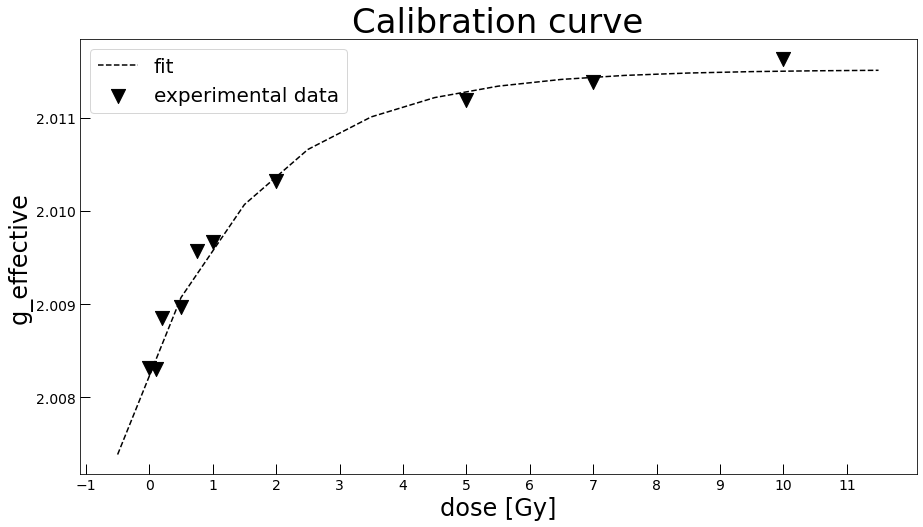

In [ ]:
plt.figure(figsize=(15,8))

plt.scatter(x_mean, y_mean, marker = 'v',c = 'black', s = 200, label='experimental data' )
x_exp = arange(min(x_mean) - 0.5, 2 + max(x_mean), 1)
y_exp = objective(x_exp, y_0, a, b)

plt.title('Calibration curve', fontsize=34)
plt.xticks(np.arange(-1, 12, step=1))
plt.tick_params(axis="x",direction="in", left="off",labelleft="on", labelsize=14)

plt.tick_params(axis="y", direction="in", left="off",labelleft="on", labelsize=14)
plt.tick_params(axis='both', which='major', length=10, width=1,  labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('dose [Gy]', fontsize=24)
plt.ylabel('g_effective', fontsize=24)
plt.plot(x_exp, y_exp, '--', color='black', label='fit')
plt.legend(loc=2, prop={'size': 20})
plt.show()

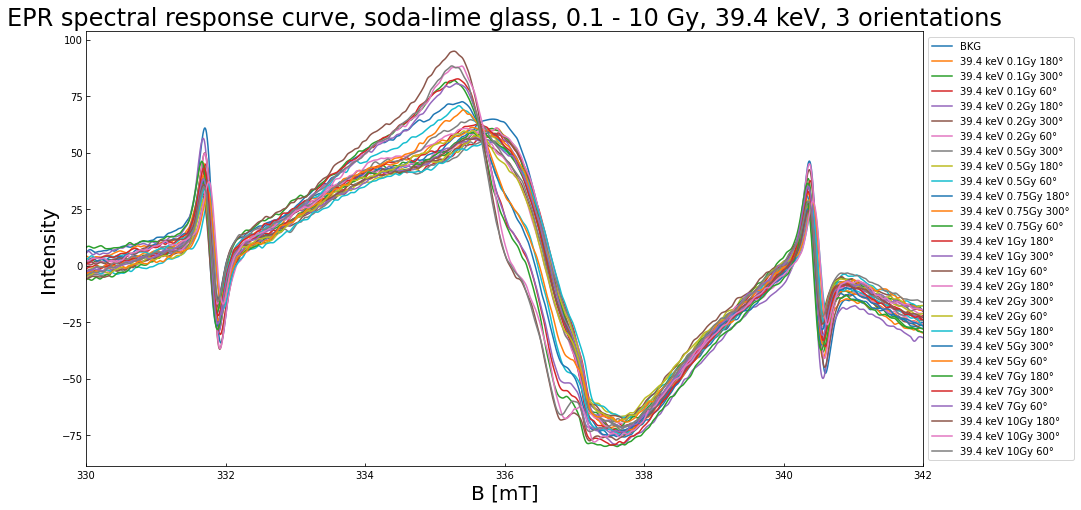

In [ ]:
#The shifting of the maximum of the EPR spectra of the irradiated soda-lime samples with the dose